<a href="https://colab.research.google.com/github/LMAPcoder/Machine-Learning-Lab/blob/main/Exercise_sheet8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab Programming Machine Learning**

## Exercise Sheet 8

### Exercise 1: Optical Character Recognition via Neural Networks

Problem: develop a Neural Network model that can classify human-written digits into either of the first 10

In [ ]:
#Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import neural_network

Loading the MNIST digits dataset

MNIST is a dataset of hand-written digits. Skilearn provide a copy with 8x8 images

In [ ]:
X,y = datasets.load_digits(return_X_y=True)

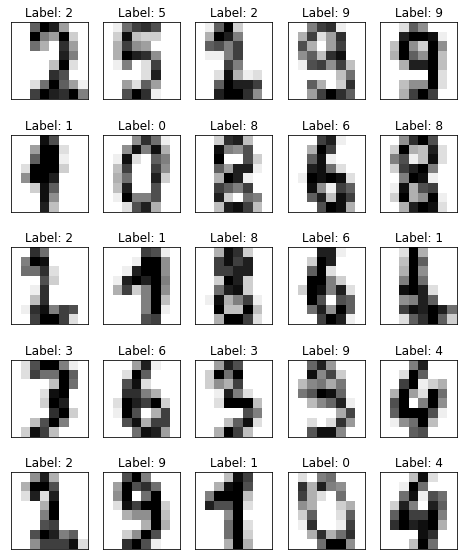

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
for i in range(5):
  for j in range(5):
    idx = np.random.randint(X.shape[0])
    ax[i,j].set_title(f'Label: {y[idx]}')
    ax[i,j].imshow(X[idx].reshape(8,8), cmap='gray_r')
    ax[i,j].axes.yaxis.set_visible(False)
    ax[i,j].axes.xaxis.set_visible(False)

Splitting of the data into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,shuffle=True)

Defining a hyperparameter grid for MLPClassifier



In [ ]:
grid = {
    'hidden_layer_sizes': [(50,),(50,20)], #(k1,k2,...,kn) where ki is the number of nodes per hidden layer. The lengh of the tuple is the number hidden layers (D) 
    'activation': ['logistic', 'relu'], #Activation function
    'alpha': [0.01,0.0001], #L2 regularization rate
    #'batch_size': [5,10],
    #'learning_rate_init': [0.1,0.01], #Initial learning rate
    'momentum': [0.2,0.5,0.8]
}

Random Search

In [ ]:
%%time
clf = neural_network.MLPClassifier(
    learning_rate='constant', #Learning rate type
    max_iter=500, #Maximum number of ephocs
    validation_fraction=0.2,
    shuffle=False
    )

GS = model_selection.RandomizedSearchCV(
    estimator=clf, #model
    param_distributions=grid, #dictionary with hyperparameters
    n_iter=5, #number of parameter settings that are sampled
    cv=5, #K-fold cross validation
    return_train_score=True #training score
)

GS.fit(X_train, y_train) 

CPU times: user 43.8 s, sys: 31.2 s, total: 1min 15s
Wall time: 38.4 s


Accuracy on test data

In [ ]:
#Classification Accuracy value
accuracy = lambda y1,y2: (y1 == y2).mean()

In [ ]:
GS.best_estimator_

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,), max_iter=500,
              momentum=0.8, shuffle=False, validation_fraction=0.2)

In [ ]:
GS.best_estimator_
y_test_pred = GS.best_estimator_.predict(X_test)

In [ ]:
accuracy(y_test,y_test_pred)

0.9777777777777777

### Exercise 2: End-to-End Self-Driving via Convolutional Neural Networks

In [ ]:
#Required libraries
import pandas as pd
import numpy as np
import zipfile as zpf
import os

Loading the data from Kaggle

In [ ]:
#Adding Kaggle credential into Kaggle directory
!mkdir ~/.kaggle
!echo '{"username":"leomap","key":"7eab106b53509e204b3efd3235b4cca1"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions

In [ ]:
%%time
#Download dataset from Kaggle
!kaggle datasets download -d 'asrsaiteja/car-steering-angle-prediction'

 99% 2.15G/2.17G [00:38<00:00, 54.1MB/s]
100% 2.17G/2.17G [00:38<00:00, 59.7MB/s]
CPU times: user 393 ms, sys: 69 ms, total: 462 ms
Wall time: 40.3 s


In [ ]:
%%time
#Unzipping files
zip_file = zpf.ZipFile('car-steering-angle-prediction.zip')
zip_file.extractall(path='/content', pwd=None)
zip_file.close()

CPU times: user 14.6 s, sys: 4.58 s, total: 19.2 s
Wall time: 34.7 s


Exploring the data

In [ ]:
files_path = '/content/driving_dataset/'
files_list = os.listdir(files_path)

print('Number of files',len(files_list))
print('Files example:',files_list[:3])

Number of files 45569
Files example: ['5586.jpg', '33043.jpg', '38432.jpg']


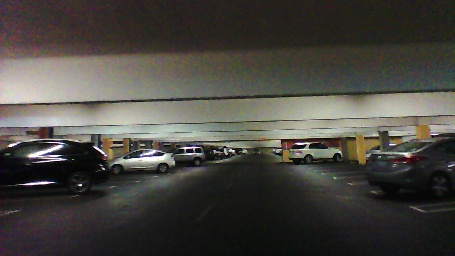

In [ ]:
from IPython.display import Image, display
display(Image(filename=f'{files_path}/24.jpg'))

# from PIL import Image
# im = Image.open(f'{files_path}/31973.jpg')
# im.show()

In [ ]:
angles = pd.read_csv(filepath_or_buffer=f'{files_path}/angles.txt',sep=' ',header=None)
print(len(angles))
angles.head()

45406


,0,1
0,0.jpg,0.0
1,1.jpg,0.0
2,2.jpg,0.0
3,3.jpg,0.0
4,4.jpg,0.0


Creating the dataset

In [ ]:
#Importing more librarie
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, functional
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from PIL import Image

In [ ]:
#This callable class take the images from the directory and convert them into tensors within a dataset object
class Dataset(Dataset): #Inherits from torch.utils.data.Dataset
    def __init__(self,files_path):
        #default directory where data is loaded
        self.filepath = files_path
        # self.filenames = os.listdir(self.filepath)

    def __len__(self):
        return len(angles)

    def __getitem__(self, index): #map-style dataset
        filename = angles.iloc[index,0]
        #Resizing images to (32, 32)
        #resized = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
        #torch.from_numpy(resized.transpose()).float(), torch.rand(1)
        img = Image.open(self.filepath + filename)
        img = functional.resize(img, size=[66,200])
        return ToTensor()(img).float(),angles.iloc[index,1]
        

In [ ]:
files_path = '/content/driving_dataset/'
dataset = Dataset(files_path)

torch.Size([3, 66, 200]) 11.7


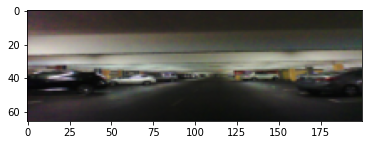

In [ ]:
import matplotlib.pyplot as plt
img, label = dataset[24]
print(img.shape, label)
plt.imshow(img.permute(1, 2, 0))

Splitting the dataset

In [ ]:
#This function generates random distributed indices and allocate them in three buckets: train, validation and test
def split_indices(N,ratio_train,ratio_valid):
    split_train = int(N*ratio_train)
    split_valid = int(N*(ratio_train+ratio_valid))
    indices = list(range(N))
    np.random.seed(3116)
    np.random.shuffle(indices)
    return indices[0:split_train], indices[split_train:split_valid], indices[split_valid:]

In [ ]:
N = len(dataset)
ratio_train = 0.6
ratio_valid = 0.18 #this ratio was selected in order to set aside 10.000 images 
train_indices, valid_indices, test_indices = split_indices(N,ratio_train,ratio_valid)
print('test indices length:',len(test_indices))

test indices length: 9990


In [ ]:
#splitting the data into batches
batch_size = 60
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset,
                           batch_size,
                           sampler = train_sampler)
valid_sampler = SubsetRandomSampler(valid_indices)
valid_loader = DataLoader(dataset, 
                           batch_size,
                           sampler = valid_sampler)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(dataset, 
                            batch_size,
                            sampler = test_sampler)
print(train_loader)

In [ ]:
for i, sample_batched in enumerate(train_loader):
  print('features',sample_batched[0].shape) #bach size (N), channels (C), height (H), width (W)
  print('targets',sample_batched[1].shape) #batch size (N)
  break

features torch.Size([60, 3, 66, 200])
targets torch.Size([60])


Defining the CNN model

In [ ]:
class ConvNet(nn.Module): #Inherits from torch.nn.Module
    def __init__(self):
        super(ConvNet, self).__init__() #equivalent to use super().__init__(self)?
        
        self.cnn_layers = nn.Sequential(
            nn.LayerNorm([3,66,200]), #Normalization
            #input channel, output channel (RGB=3) (number of filters), kernel size, stride, padding
            nn.Conv2d(3, 24, 5, 2), #Convolutial feature map
            nn.Conv2d(24, 36, 5, 2), 
            nn.Conv2d(36, 48, 5, 2),
            nn.Conv2d(48, 64, 3),
            nn.Conv2d(64, 64, 3),
            nn.Flatten() #flatten the tensors within the batches
        )
         
        self.linear_layers = nn.Sequential(
            nn.Linear(1152,100), #input size, output size
            nn.ELU(),
            nn.Linear(100 ,50),
            nn.ELU(),
            nn.Linear(50 ,10),
            nn.ELU(),
            nn.Linear(10 ,1)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.shape[0],-1) #return a copy
        x = self.linear_layers(x)
        x = x.view(len(x))
        return x

Loading data and model on GPU

Credits: Aakash Rao

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)): #this condition allows us to work not only with simply tensors but with list of tensor
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) #yield retain the items

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#Loading data on GPU
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Inizializating model and training

In [ ]:
net = ConvNet()
to_device(net,device) #loading model on GPU
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

In [ ]:
#Root Mean Square Error
def RMSE(loader):
  mse = 0
  with torch.no_grad():
    for xb,yb in loader:
      preds = net(xb)
      mse += loss_fn(preds,yb.float())
  rmse = torch.sqrt(mse)
  return rmse.item()

In [ ]:
def fit(epochs, model, loss_fn, opt, train_loader):
  for epoch in range(epochs):
    model.train()
    for idx,(xb,yb) in enumerate(train_loader):
      opt.zero_grad() #to prevent accumulation
      preds = model(xb)
      loss = loss_fn(preds,yb.float())
      # print('batch:',idx,'loss: ',loss.item())
      loss.backward()
      opt.step()
    print('epoch:',epoch,'RMSE: ',RMSE(train_loader))

In [ ]:
%%time
epochs = 5
fit(epochs, net, loss_fn, optimizer, train_loader)

epoch: 0 RMSE:  654.2206420898438
epoch: 1 RMSE:  654.215087890625
epoch: 2 RMSE:  654.3999633789062
epoch: 3 RMSE:  654.334228515625
epoch: 4 RMSE:  654.2410278320312
CPU times: user 14min 28s, sys: 11.5 s, total: 14min 40s
Wall time: 14min 37s


Test accuracy

In [ ]:
RMSE(test_loader)

391.6792907714844